In [17]:
! pip install pydub
! pip install noisereduce
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
# Download dataset from Kaggle (direct link: https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en)
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

speech-emotion-recognition-en.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir ./data

In [ ]:
%%capture
!unzip speech-emotion-recognition-en.zip -d ./data

In [ ]:
import numpy as np
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import librosa

In [21]:
emotions = {
  'happy': 0, 
  'sad': 1, 
  'angry': 2
}

ravdess_emotions = {
    '03': emotions['happy'],
    '04': emotions['sad'],
    '05': emotions['angry']
}

crema_emotions = {
  'SAD': emotions['sad'], 
  'ANG': emotions['angry'],
  'HAP': emotions['happy']
}

savee_emotions = {
    'a': emotions['angry'],
    'h': emotions['happy']
}

processed_data = []

data_path = "/content/data"
for root, dirs, files in os.walk(data_path):
  for file in files:
    file_path = os.path.join(root, file)

    emotion_label = None

    dataset = file_path.split('/')[3]
    if dataset == 'Ravdess':
      emotion_label = ravdess_emotions.get(file.split('-')[2], None)
    elif dataset == 'Crema':
      emotion_label = crema_emotions.get(file.split('_')[2], None)
    elif dataset == 'Tess':
      emotion_label = emotions.get(file.split('_')[2].split('.')[0], None)
    elif dataset == 'Savee':
      emotion_code = file.split('_')[1][:2]
      if (emotion_code == 'sa'):
        emotion_label = emotions['sad']
      else:
        emotion_label = savee_emotions.get(emotion_code[0], None)

    if (emotion_label != None):
      processed_data.append([file_path, dataset, emotion_label])

In [22]:
import noisereduce as nr
from pydub import AudioSegment, effects


frame_length = 2048
hop_length = 512
total_length = 157409 # verify this value?

def extract_feature(file_name): 

    y, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

    # Don't process corrupted audio signals
    if not np.any(y):
        return None

    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sample_rate,n_mfcc=40).T, axis=0)

    return mfccs

def extract_all_features(file_name):

    y, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

    # Don't process corrupted audio signals
    if not np.any(y):
        return None

    rawsound = AudioSegment.from_file(file_name) 
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Pad for duration equalization.
    padded_x = librosa.util.fix_length(xt, size=total_length)
    # Noise reduction.
    final_x = nr.reduce_noise(y=padded_x, sr=sample_rate)        

    stft = np.abs(librosa.stft(final_x))
    result=np.array([])
    
    mfccs=np.mean(librosa.feature.mfcc(y=final_x, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))

    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))

    mel=np.mean(librosa.feature.melspectrogram(final_x, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))

    return result        

In [23]:
# Obtain features from each wav file
labels = []
features = []

i = 0 # partially save results?
for data in processed_data:
    i += 1
    result = extract_feature(data[0])
    if result is not None:
        labels.append(data[2])
        features.append(result)
    if i%500 == 0:
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [27]:
# Create np arrays for data and labels
X = np.array(features)
Y = np.array(labels)

In [28]:
# shuffle X and Y same way
# random_state to seed the shuffle
# X, Y = shuffle(X, Y, random_state=0)
print(X.shape)
print(Y.shape)

(5768, 40)
(5768,)


In [29]:
#numpy save x and y
#zip together before saving?
x_path = './x_data'
y_path = './y_data'
np.save(x_path, X)
np.save(y_path, Y)

In [30]:
! zip allData_threeEmotions.zip x_data.npy y_data.npy

  adding: x_data.npy (deflated 6%)
  adding: y_data.npy (deflated 95%)


In [ ]:
import numpy as np
import os
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import librosa

import tensorflow as tf
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
X_train_0, X_test, y_train_0, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_0, y_train_0, test_size=0.18, random_state=42) # 0.18 x 0.85 = 0.15

In [ ]:
#####################################################
#                 Model Section                     #
#####################################################

x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)

print(x_traincnn.shape, x_valcnn.shape)

model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(128, 5, padding='same',
                    input_shape=(182, 1)))
model.add(Activation('relu'))
model.add(tf.keras.layers.MaxPool1D())
model.add(Conv1D(176, 5, padding='same'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.MaxPool1D())
model.add(Conv1D(240, 5, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

history = model.fit(x_traincnn, y_train,
                        batch_size=16, epochs=50,
                        validation_data=(x_valcnn, y_val))

(2701, 180, 1) (593, 180, 1)
<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f5a0d984910>>
Epoch 1/50
169/169 [==============================] - 14s 77ms/step - loss: 1.3594 - accuracy: 0.5254 - val_loss: 1.0682 - val_accuracy: 0.6779
Epoch 2/50
169/169 [==============================] - 13s 77ms/step - loss: 0.9811 - accuracy: 0.6731 - val_loss: 0.9012 - val_accuracy: 0.6931
Epoch 3/50
169/169 [==============================] - 13s 77ms/step - loss: 0.8516 - accuracy: 0.7197 - val_loss: 0.9058 - val_accuracy: 0.6830
Epoch 4/50
169/169 [==============================] - 13s 77ms/step - loss: 0.7840 - accuracy: 0.7360 - val_loss: 0.9167 - val_accuracy: 0.6880
Epoch 5/50
169/169 [==============================] - 13s 76ms/step - loss: 0.7275 - accuracy: 0.7549 - val_loss: 0.8254 - val_accuracy: 0.7116
Epoch 6/50
169/169 [==============================] - 13s 76ms/step - loss: 0.7090 - accuracy: 0.7634 - val_loss: 0.8531 - val_accuracy: 0.7268
Epoch 7/50
16

In [ ]:
index_to_emotion = {
    0:"happy",
    1:"sad",
    2:"angry",
    3:"disgust",
    4:"fear",
    5:"neutral"
}

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=4):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [ ]:
x = record()

TypeError: ignored

In [ ]:
import IPython.display as ipd
ipd.Audio(np.array(x.get_array_of_samples(), dtype = 'float32'), rate=x.frame_rate) # load a NumPy array

AttributeError: ignored

In [ ]:
sample_rate = x.frame_rate
y = np.array(x.get_array_of_samples(), dtype = 'float32')

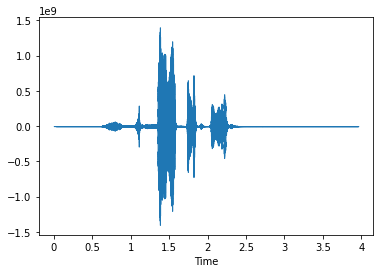

In [ ]:
# from librosa import display as dps
# dps.waveshow(y, sr=sr)

In [ ]:
X_fresh = np.array(result)
X_fresh = X_fresh.reshape((1, X_fresh.shape[0]))
X_fresh = np.expand_dims(X_fresh, axis=2)

In [ ]:
out = model.predict(X_fresh, verbose=1)

1/1 [==============================] - 0s 24ms/step


In [ ]:
# emotion is argmax of out
print(out)
idx = np.argmax(out, axis=1)
print(index_to_emotion[idx[0]])

[[0. 0. 0. 0. 0. 1.]]
neutral
